### hierarchical learning / learning by association on cifar 100
A cifarnet model (https://github.com/tensorflow/models/blob/master/slim/nets/cifarnet.py) was trained on cifar100, with walker, visit, and logit losses. Coarse labels were added to incude a more hierarchical structure to the labels. The training data was split half/half for supervised and unsupervised training.

Coarse labels worked ok: they don't change the result much. 

However, the accuracy doesn't benefit from associative learning, and the walker/visit loss is mostly constant (see below)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import scipy
import cPickle
%matplotlib inline
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
tf.__version__

'1.0.1'

### Loading of the data

The 32x32 CIFAR images we use here can be obtained from: http://www.cs.toronto.edu/~kriz/cifar.html 

In [2]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    data = dict['data']
    imgs = np.transpose(np.reshape(data,(-1,32,32,3), order='F'),axes=(0,2,1,3)).astype(np.float) #order batch,x,y,color
    y = np.asarray(dict['fine_labels'], dtype='uint8')
    return y, imgs

In [119]:
y, imgs = unpickle('/usr/stud/plapp/data/cifar100/test')

y.shape, imgs.shape

((10000,), (10000, 32, 32, 3))

### Defining the models

We use a trained cifarnet network. Use lba to train it.

In [147]:
import semisup

from tools.cifar100 import tree
from tools.tree import findLabelsFromTree, findLabelsFromTreeMultitask, getWalkerLabel
from tools import cifar100 as cifar_tools, dataset_factory, preprocessing_factory, cifar100, data_dirs


tf.reset_default_graph()
model_path='/usr/stud/plapp/models/multitask_half/model.ckpt-35489'
model_path='/usr/stud/plapp/models/lba_multitask_half/model.ckpt-39202'


preprocessing_name = "cifarnet"#FLAGS.preprocessing_name or FLAGS.model_name
image_preprocessing_fn = preprocessing_factory.get_preprocessing(
  preprocessing_name,
  is_training=False)


image = tf.placeholder(tf.float32, [32,32,3])


test_images = image_preprocessing_fn(image, 32, 32)


model = semisup.SemisupModel(semisup.architectures.cifar_model, tree.num_labels,
                             [32,32,3], treeStructure=tree)

variables_to_restore = slim.get_variables_to_restore()
print('Number of variables to restore {}'.format(len(variables_to_restore)))

init_assign_op, init_feed_dict = slim.assign_from_checkpoint(model_path, variables_to_restore)
sess = tf.Session()
sess.run(init_assign_op, init_feed_dict)  


shape (?, 32, 32, 3)
Number of variables to restore 11


In [120]:
# preprocess images (same as in tf slim example)
for i in range(10000):
    imgs[i] = test_images.eval(feed_dict={image: imgs[i]}, session=sess)

In [148]:
g = tf.get_default_graph()

feed = g.get_tensor_by_name('test_in:0')
fetch = g.get_tensor_by_name('net/fc4/Relu:0')
label = g.get_tensor_by_name('net_1/fully_connected/BiasAdd:0')

# Feeding images through the net
feed_vals = imgs[0:5000]
res = sess.run([fetch, label], feed_dict={feed:feed_vals})
np.shape(feed_vals), res[1].shape, res[0].shape

((5000, 32, 32, 3), (5000, 120), (5000, 192))

## Investigation of hierachical structure
The hierarchical training is formulated as multitask learning: the network has to predict both the 20 coarse labels (nodes) and 100 fine labels (leafs).
This multitask learning doesn't really change the accuracy of the network. During inference, it's slightly better to directly use the fine class labels, ignoring the coarse labels:

In [149]:
correct=[]
correct_coarse=[]
not_correct_but_coarse=[]
correct_but_not_coarse=[]
subset_wrong=[]
s=5000
for j in range(s):
    tree_label = findLabelsFromTree(tree, res[1][j])
    label = findLabelsFromTreeMultitask(tree, res[1][j])
    coarse_label = int(np.math.floor((labels[j]) / 5))
    
    if label[1] == labels[j]:
        correct = correct + [j]
        if label[0] != coarse_label:
            correct_but_not_coarse = correct_but_not_coarse + [j]
            
    if label[0] == coarse_label:
        correct_coarse = correct_coarse + [j]
        if tree_label[0][1] != labels[j]:
            subset_wrong = subset_wrong + [j]
        if label[1] != labels[j]:
            not_correct_but_coarse = not_correct_but_coarse + [j]
            
        
print "fine accuracy:", float(len(correct))/s
print "coarse accuracy:", float(len(correct_coarse))/s
print "coarse prediction is right, but fine fails:", float(len(not_correct_but_coarse))/s
print "coarse prediction is right, but fine fails also on subset of tree:", float(len(subset_wrong))/s
print "coarse prediction is wrong, fine still right:", float(len(correct_but_not_coarse))/s

fine accuracy: 0.4656
coarse accuracy: 0.483
coarse prediction is right, but fine fails: 0.0758
coarse prediction is right, but fine fails also on subset of tree: 0.041
coarse prediction is wrong, fine still right: 0.0584


In [ ]:
# have a look at single image
i=1

print "ground truth:", labels[i]
s = res[1][i][0:20].argsort()[-10:][::-1]
print "most likely coarse classes:", s
print "related logits:", np.sort(res[1][i][0:20])[-5:][::-1]

print "direct prediction:", findLabelsFromTreeMultitask(tree, res[1][i])[1]  
print "prediction from tree:", findLabelsFromTree(tree, res[1][i])  
print "fine class logits for pred 0:", res[1][i][s[0]*5+20:s[0]*5+25]
print "fine class logits for pred 1:", res[1][i][s[1]*5+20:s[1]*5+25]
print "fine class logits for pred 2:", res[1][i][s[2]*5+20:s[2]*5+25]
print "fine class logits for ground truth coarse:", res[1][i][int(np.floor((y[i]-1)/5)*5+20):int(np.floor((y[i]-1)/5)*5+25)]

# Embeddings
As expected, from the closest 10 sampels to a sample, on average about `25%` have the same label. 
One would hope that due to the walker / visit loss on the _coarse_ labels, this would increase. It increases only slightly to `29.5%` though: (coarse label is the same if fine label is the same, so it's always larger)

In [151]:
s = 5000  # number of samples

from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(res[0])

similar_coarse_labels = np.zeros(s)
similar_fine_labels = np.zeros(s)
labels = (y+99) % 100 #fix labels

for j in range(s):        
    coarse_label = int(np.math.floor((labels[j]) / 5))
    label = [coarse_label, labels[j]]
    
    # closest 10 embeddings
    closest_embeddings = (similarities[j][:]).argsort()[-11:-1][::-1]
    
    labels_for_closest_embeddings = [[int(np.math.floor((labels[i]) / 5)),labels[i]] for i in closest_embeddings]
    
    same_coarse_label = [l[0] == label[0] for l in labels_for_closest_embeddings]
    same_fine_label = [l[1] == label[1] for l in labels_for_closest_embeddings]
    
    similar_coarse_labels[j] = np.average(same_coarse_label)
    similar_fine_labels[j] = np.average(same_fine_label)
    
    #print(coarse_label, np.average(same_coarse_label), )
    #if np.average(same_fine_label) > 0.5:
    #    print(j)
    
print("coarse similarity of closest embeddings:", np.average(similar_coarse_labels))
print("fine similarity of closest embeddings:", np.average(similar_fine_labels))

('coarse similarity of closest embeddings:', 0.34834999999999999)
('fine similarity of closest embeddings:', 0.31409999999999999)


## Losses
For this model, there is a logit loss on coarse and fine labels.
Additionaly, there is a walker+visit loss only on the coarse labels. During training, this loss doesn't change much, only logit losses decrease:
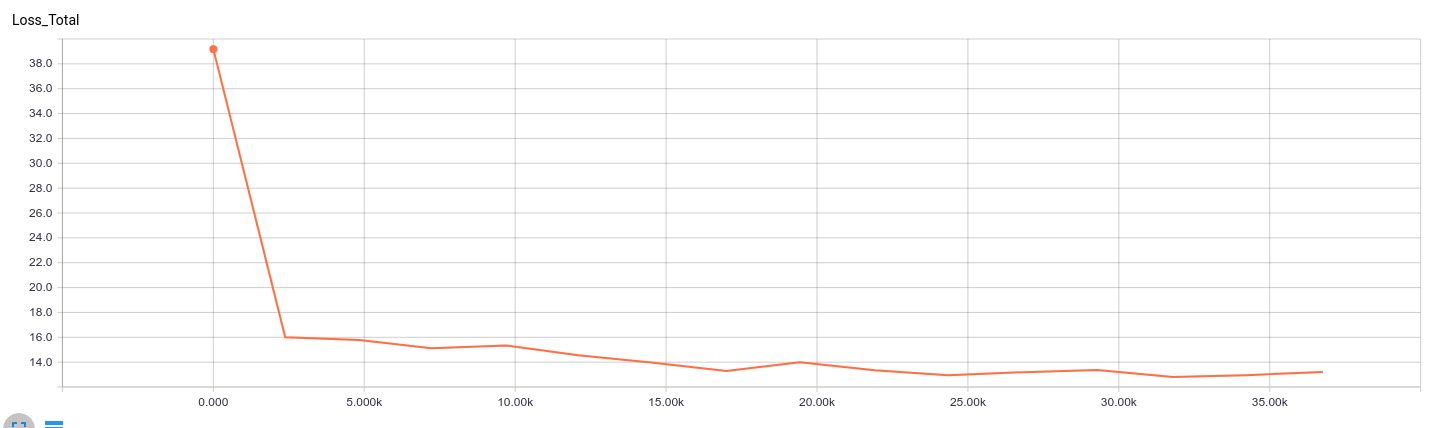
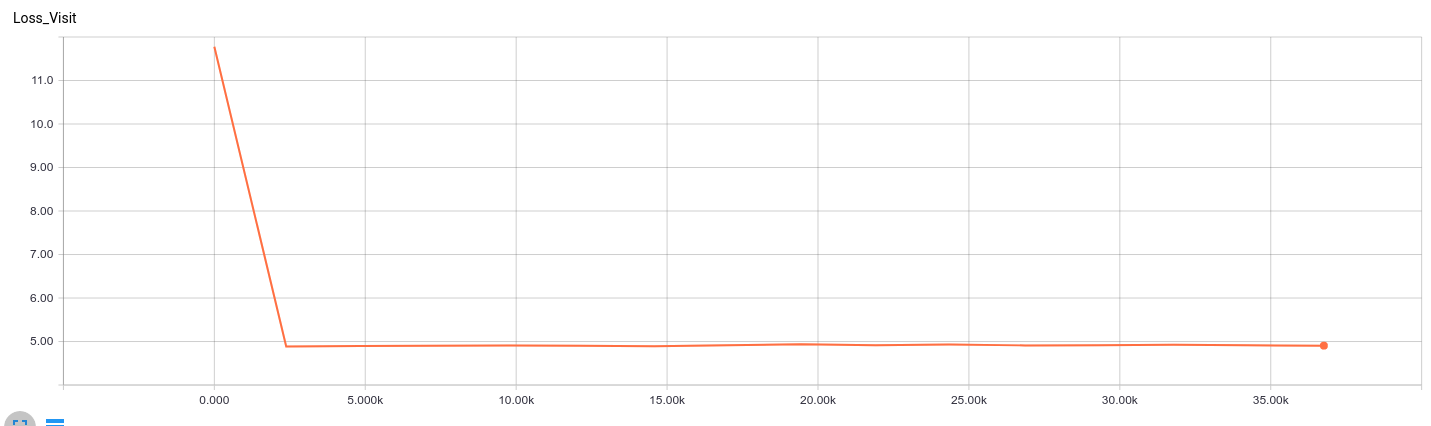
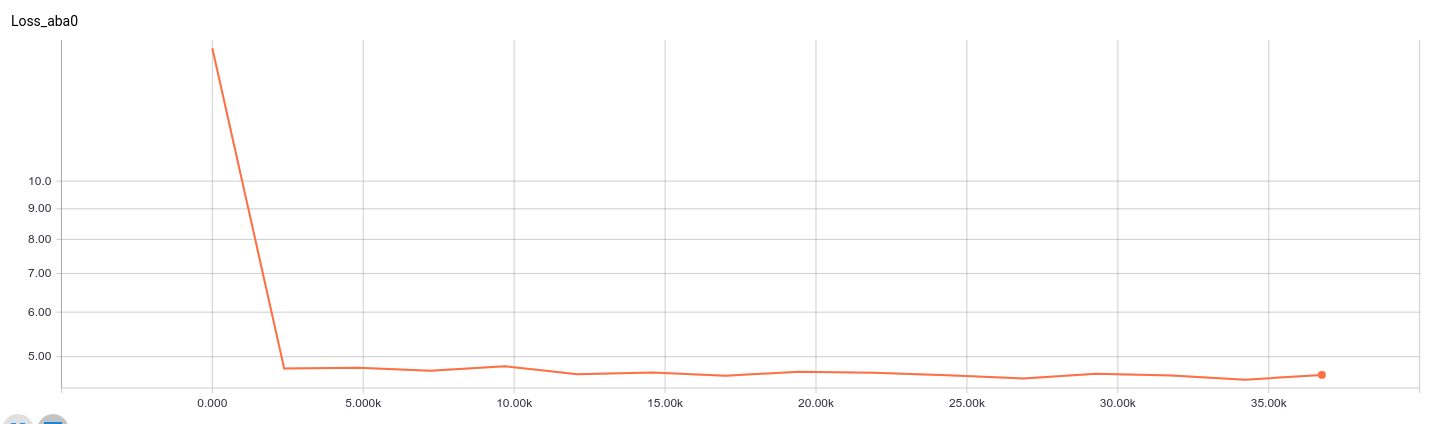

### More things: Getting embeddings into tensorboard

We now create a $N \times p$ matrix holding the embeddings, for the N images. For simplycify, we do this by feeding the images one after another through the network (of course we could have also used minibatches). We store this matrix in `EMB` to use it later.

In [54]:
N = imgs.shape[0]
N = 2000 #For testing 
p = res[0].shape[1]

EMB = np.zeros((N, p), dtype='float32')
for i in range(N): #Of course you could do mini-batches
    EMB[i] = sess.run(fetch, feed_dict={feed: imgs[i:i+1,:]})
    if (i % 50 == 0 or i < 5):
        print(i)

0
1
2
3
4
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950


### Writing out the embedding matrix
We now write out the embedding matrix in the proper format needed for the visualizer. If you don't want images or meta data, just comment out the respective parts.

In [55]:
LOG_DIR = '/usr/stud/plapp/cifarVisualization'

# The embedding variable, which needs to be stored
# Note this must a Variable not a Tensor!
embedding_var = tf.Variable(EMB,  name='Embedding_of_fc4')
sess.run(embedding_var.initializer)
summary_writer = tf.summary.FileWriter(LOG_DIR)
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# Comment out if you don't have metadata
embedding.metadata_path = os.path.join(LOG_DIR, 'metadata.tsv')

# Comment out if you don't want sprites
#embedding.sprite.image_path = os.path.join(LOG_DIR, 'sprite.png')
#embedding.sprite.single_image_dim.extend([imgs.shape[1], imgs.shape[1]])

projector.visualize_embeddings(summary_writer, config)
saver = tf.train.Saver([embedding_var])
saver.save(sess, os.path.join(LOG_DIR, 'model5.ckpt'), 1)

'/usr/stud/plapp/cifarVisualization/model5.ckpt-1'

### Creation of the meta data (labels)

In [56]:
names = ['plane','auto','bird','cat','deer','dog','frog','horse','ship','truck']
metadata_file = open(os.path.join(LOG_DIR, 'metadata.tsv'), 'w')
metadata_file.write('Name\tClass\n')
for i in range(N):
    metadata_file.write('%06d\t%s\n' % (i, 'class'+str(y[i])))
metadata_file.close()

### Creation of the images

In [29]:
# Taken from: https://github.com/tensorflow/tensorflow/issues/6322
def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding

    Args:
      data: NxHxW[x3] tensor containing the images.

    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min).transpose(3,0,1,2)
    max = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max).transpose(3,0,1,2)
    # Inverting the colors seems to look better for MNIST
    #data = 1 - data

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0),
            (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant',
            constant_values=0)
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3)
            + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data

In [30]:
sprite = images_to_sprite(imgs)
scipy.misc.imsave(os.path.join(LOG_DIR, 'sprite.png'), sprite)

In [19]:
%ls -lhl /tmp/dumm/ 

total 139768
-rw-r--r--  1 oli  wheel   103B Dec 16 18:36 checkpoint
-rw-r--r--  1 oli  wheel    12K Dec 16 18:36 metadata.tsv
-rw-r--r--  1 oli  wheel    16M Dec 16 18:36 model2.ckpt-1.data-00000-of-00001
-rw-r--r--  1 oli  wheel   147B Dec 16 18:36 model2.ckpt-1.index
-rw-r--r--  1 oli  wheel    31M Dec 16 18:36 model2.ckpt-1.meta
-rw-r--r--  1 oli  wheel   199B Dec 16 18:36 projector_config.pbtxt
-rw-r--r--  1 oli  wheel    21M Dec 16 18:36 sprite.png
